## QA of ingested values in h3

Notebook for checking the calculated values during ingestion. As part of this notebook we can also estimate the differences that the use of h3 is producing on the calculations. Therefore we are going to double check:

- 1. Differences between harvest area and production in an AOI using the raster file vs the h3 data. Check that we have the same values using the ddbb

- 2. Differences between contextual outputs in an AOI using the raster file vs the h3 data. Check that we have the same values using the ddbb

- 3. Differences between the impact calculations using raster and h3. Check that we have the same values in the ddbb.

Data:

- The ingested data that we are going to double check is based on the following excel spreadsheet: https://docs.google.com/spreadsheets/d/1dWeyKY6RNJAO74H3pXcwyOfVQm7oBW2cVsjHDY4cP4U/edit#gid=0

- The outputs of the analysis will be sumarised in the following excel spreadsheet: https://docs.google.com/spreadsheets/d/19_9RROAGgXaxB46pk-iQOOfnhxd8jOw_rN904XhRtjk/edit#gid=2130708208


In [16]:
!pip install h3ronpy --q 

In [19]:
## import libraries
# import libraries
from psycopg2.pool import ThreadedConnectionPool

import pandas as pd
import geopandas as gpd
#from tqdm import tqdm
import urllib.request 
import os
from zipfile import ZipFile
#import json

#import h3
#import h3pandas
from h3ronpy import raster
import rasterio as rio
from rasterstats import zonal_stats


In [20]:
#set env
## env file for gcs upload
env_path = ".env"
with open(env_path) as f:
    env = {}
    for line in f:
        env_key, _val = line.split("=", 1)
        env_value = _val.split("\n")[0]
        env[env_key] = env_value
        
#list(env.keys())

# set conexion to local ddbb
postgres_thread_pool = ThreadedConnectionPool(
    1, 
    50,
    host=env['API_POSTGRES_HOST'],
    port=env['API_POSTGRES_PORT'],
    user=env['API_POSTGRES_USERNAME'],
    password=env['API_POSTGRES_PASSWORD']
)

#get list of sourcing records to iterate:
conn = postgres_thread_pool.getconn()
cursor = conn.cursor()

In [21]:
# define functions

SQL_GET_H3_UNCOMPACT_GEO_REGION = """
CREATE OR REPLACE FUNCTION get_h3_uncompact_geo_region(geo_region_id uuid, h3_resolution int)
RETURNS TABLE (h3index h3index) AS 
$$
    SELECT h3_uncompact(geo_region."h3Compact"::h3index[], h3_resolution) h3index
    FROM geo_region WHERE geo_region.id = geo_region_id
$$ 
LANGUAGE SQL;
"""

SQL_SUM_H3_GRID_OVER_GEO_REGION = SQL_GET_H3_UNCOMPACT_GEO_REGION+"""
CREATE OR REPLACE FUNCTION sum_h3_grid_over_georegion(
    geo_region_id uuid, 
    h3_resolution int,
    h3_table_name varchar, 
    h3_column_name varchar
)
RETURNS float AS
$$
    DECLARE
        sum float;
    BEGIN
        EXECUTE format(
            'SELECT sum(h3grid.%I)
                FROM
                    get_h3_uncompact_geo_region($1, $2) geo_region
                    INNER JOIN %I h3grid ON h3grid.h3index = geo_region.h3index;
            ', h3_column_name, h3_table_name)
            USING geo_region_id, h3_resolution
            INTO sum;
        RETURN sum;
    END;
$$
LANGUAGE plpgsql;
"""

SQL_SUMPROD_H3_GRIDS_OVER_GEOREGION = SQL_GET_H3_UNCOMPACT_GEO_REGION+"""
CREATE OR REPLACE FUNCTION sumprod_h3_grids_over_georegion(
    geo_region_id uuid,
    h3_resolution int,
    h3_table_name_1 varchar,
    h3_column_name_1 varchar,
    h3_table_name_2 varchar,
    h3_column_name_2 varchar
)
RETURNS float AS
$$
    DECLARE
        sumprod float;
    BEGIN
        EXECUTE format(
            'SELECT sum(h3grid_1.%I * h3grid_2.%I)
                FROM
                    get_h3_uncompact_geo_region($1, $2) geo_region
                    INNER JOIN %I h3grid_1 ON h3grid_1.h3index = geo_region.h3index
                    INNER JOIN %I h3grid_2 ON h3grid_2.h3index = geo_region.h3index;
            ', h3_column_name_1, h3_column_name_2, h3_table_name_1, h3_table_name_2)
            USING geo_region_id, h3_resolution
            INTO sumprod;
        RETURN sumprod;
    END;
$$
LANGUAGE plpgsql;
"""

SQL_GET_H3_TABLE_COLUMN_FOR_MATERIAL = """
CREATE OR REPLACE FUNCTION get_h3_table_column_for_material(material_id uuid, h3_data_type material_to_h3_type_enum)
RETURNS TABLE (h3_table_name varchar, h3_column_name varchar, h3_resolution int) AS
$$
    SELECT h3_data."h3tableName", h3_data."h3columnName", h3_data."h3resolution"
    FROM h3_data
        INNER JOIN material_to_h3 ON material_to_h3."h3DataId" = h3_data.id
    WHERE material_to_h3."materialId" = material_id 
        AND material_to_h3.type = h3_data_type
    LIMIT 1;
$$
LANGUAGE SQL;
"""

SQL_SUM_MATERIAL_OVER_GEO_REGION = SQL_SUM_H3_GRID_OVER_GEO_REGION+SQL_GET_H3_TABLE_COLUMN_FOR_MATERIAL+"""
CREATE OR REPLACE FUNCTION sum_material_over_georegion(
    geo_region_id uuid, 
    material_id uuid,
    h3_data_type material_to_h3_type_enum
)
RETURNS float AS
$$
    DECLARE
        h3_table_name varchar;
        h3_column_name varchar;
        h3_resolution integer;
        sum float;

    BEGIN
        -- Get h3data table name and column name for given material
        SELECT * INTO h3_table_name, h3_column_name, h3_resolution
        FROM get_h3_table_column_for_material(material_id, h3_data_type);

        -- Sum table column over region
        SELECT sum_h3_grid_over_georegion(geo_region_id, h3_resolution, h3_table_name, h3_column_name) 
        INTO sum;
        RETURN sum;
    END;
$$
LANGUAGE plpgsql;
"""

SQL_SUM_WEIGHTED_DEFORESTATION_OVER_GEO_REGION = """
CREATE OR REPLACE FUNCTION sum_weighted_deforestation_over_georegion(
    geo_region_id uuid, 
    material_id uuid,
    h3_data_type material_to_h3_type_enum
)
RETURNS float AS
$$
    DECLARE
        material_h3_table_name varchar;
        material_h3_column_name varchar;
        h3_resolution integer;
        deforestation_h3_table_name varchar := 'h3_grid_deforestation_global';
        deforestation_h3_column_name varchar := 'hansenLoss2019';
        sum float;

    BEGIN
        -- Get h3data table name and column name for given material
        SELECT * INTO material_h3_table_name, material_h3_column_name, h3_resolution
        FROM get_h3_table_column_for_material(material_id, h3_data_type);

        -- Sum table column over region
        EXECUTE format(
            'SELECT sum(h3grid_mat.%I * h3grid_def.%I)
                FROM
                    get_h3_uncompact_geo_region($1, $2) geo_region
                    INNER JOIN %I h3grid_mat ON h3grid_mat.h3index = geo_region.h3index
                    INNER JOIN %I h3grid_def ON h3grid_def.h3index = geo_region.h3index;
            ', material_h3_column_name, deforestation_h3_column_name, material_h3_table_name, deforestation_h3_table_name)
            USING geo_region_id, h3_resolution
            INTO sum;
        RETURN sum;
    END;
$$
LANGUAGE plpgsql;
"""

SQL_SUM_WEIGHTED_BIODIVERSITY_OVER_GEO_REGION = """
CREATE OR REPLACE FUNCTION sum_weighted_biodiversity_over_georegion(
    geo_region_id uuid, 
    material_id uuid,
    h3_data_type material_to_h3_type_enum
)
RETURNS float AS
$$
    DECLARE
        material_h3_table_name varchar;
        material_h3_column_name varchar;
        h3_resolution integer;
        deforestation_h3_table_name varchar := 'h3_grid_deforestation_global';
        deforestation_h3_column_name varchar := 'hansenLoss2019';
        bio_h3_table_name varchar := 'h3_grid_bio_global';
        bio_h3_column_name varchar := 'lciaPslRPermanentCrops';
        sum float;

    BEGIN
        -- Get h3data table name and column name for given material --
        SELECT * INTO material_h3_table_name, material_h3_column_name, h3_resolution
        FROM get_h3_table_column_for_material(material_id, h3_data_type);

        -- Sum deforestation times biodiversity where material is produced --
        EXECUTE format(
                'SELECT sum(h3grid_mat.%I * h3grid_def.%I * h3grid_bio.%I * (1/0.0001))
                    FROM get_h3_uncompact_geo_region($1, $2) geo_region
                        INNER JOIN %I h3grid_mat ON h3grid_mat.h3index = geo_region.h3index
                        INNER JOIN %I h3grid_def ON h3grid_def.h3index = geo_region.h3index
                        INNER JOIN %I h3grid_bio ON h3grid_bio.h3index = geo_region.h3index;', 
                material_h3_column_name, 
                deforestation_h3_column_name, 
                bio_h3_column_name,
                material_h3_table_name,
                deforestation_h3_table_name,
                bio_h3_table_name
            )
            USING geo_region_id, h3_resolution
            INTO sum;
        RETURN sum;
    END;
$$
LANGUAGE plpgsql;
"""

SQL_SUM_WEIGHTED_CARBON_OVER_GEO_REGION = """
CREATE OR REPLACE FUNCTION sum_weighted_carbon_over_georegion(
    geo_region_id uuid, 
    material_id uuid,
    h3_data_type material_to_h3_type_enum
)
RETURNS float AS
$$
    DECLARE
        material_h3_table_name varchar;
        material_h3_column_name varchar;
        h3_resolution integer;
        deforestation_h3_table_name varchar := 'h3_grid_deforestation_global';
        deforestation_h3_column_name varchar := 'hansenLoss2019';
        carbon_h3_table_name varchar := 'h3_grid_carbon_global';
        carbon_h3_column_name varchar := 'earthstat2000GlobalHectareEmissions';
        sum float;

    BEGIN
        -- Get h3data table name and column name for given material --
        SELECT * INTO material_h3_table_name, material_h3_column_name, h3_resolution
        FROM get_h3_table_column_for_material(material_id, h3_data_type);

        -- Sum deforestation times carbon where material is produced --
        EXECUTE format(
                'SELECT sum(h3grid_mat.%I * h3grid_def.%I * h3grid_carbon.%I)
                    FROM get_h3_uncompact_geo_region($1, $2) geo_region
                        INNER JOIN %I h3grid_mat ON h3grid_mat.h3index = geo_region.h3index
                        INNER JOIN %I h3grid_def ON h3grid_def.h3index = geo_region.h3index
                        INNER JOIN %I h3grid_carbon ON h3grid_carbon.h3index = geo_region.h3index;', 
                material_h3_column_name, 
                deforestation_h3_column_name, 
                carbon_h3_column_name,
                material_h3_table_name,
                deforestation_h3_table_name,
                carbon_h3_table_name
            )
            USING geo_region_id, h3_resolution
            INTO sum;
        RETURN sum;
    END;
$$
LANGUAGE plpgsql;
"""

SQL_SUM_WEIGHTED_WATER_OVER_GEO_REGION = """
CREATE OR REPLACE FUNCTION sum_weighted_water_over_georegion(
    geo_region_id uuid
)
RETURNS float AS
$$
    DECLARE
        water_h3_table_name varchar := 'h3_grid_wf_global';
        water_h3_column_name varchar := 'wfBltotMmyrT';
        h3_resolution integer := 6;
        sum float;

    BEGIN

        -- Sum deforestation times carbon where material is produced --
        EXECUTE format(
                'SELECT sum(h3grid_water.%I * 0.001)
                    FROM get_h3_uncompact_geo_region($1, $2) geo_region
                        INNER JOIN %I h3grid_water ON h3grid_water.h3index = geo_region.h3index;', 
                water_h3_column_name, 
                water_h3_table_name
            )
            USING geo_region_id, h3_resolution
            INTO sum;
        RETURN sum;
    END;
$$
LANGUAGE plpgsql;
"""

In [5]:
# define functions raster to h3

def donwloadZipFile(data_url, output_folder, filename):
    """
    Input
    ------
    data_url [string] : data url to download
    output_filder [string]: output folder to save the downloaded data
    filename: name of the saved file"""
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print('Output folder created!')
    else:
        pass
        print('Output folder already exists!')
        
    urllib.request.urlretrieve(data_url, output_folder+f"/{filename}")
    
    with ZipFile(output_folder+f"/{filename}", 'r') as zipObj:
   # Extract all the contents of zip file in different directory
       zipObj.extractall(output_folder)
    print('Data extracted!')
    print('Done!')
    


# 1 . QA materials ingestion:

In [22]:
path = "../../datasets/raw"
output_folder = path + '/qa_values'
#output_file = output_folder+"/rubber_HarvAreaYield_Geotiff.zip
data_url = "https://s3.us-east-2.amazonaws.com/earthstatdata/HarvestedAreaYield175Crops_Indvidual_Geotiff/rubber_HarvAreaYield_Geotiff.zip"


In [25]:
donwloadZipFile(data_url, output_folder, filename='rubber_HarvAreaYield_Geotiff.zip')

Output folder already exists!
Data extracted!
Done!


In [6]:
[file for file in os.listdir(output_folder+ '/rubber_HarvAreaYield_Geotiff') if file.endswith('.tif')]

['rubber_HarvestedAreaHectares.tif',
 'rubber_Production.tif',
 'rubber_HarvestedAreaFraction.tif',
 'rubber_DataQuality_Yield.tif',
 'rubber_YieldPerHectare.tif',
 'rubber_DataQuality_HarvestedArea.tif']

In [9]:
# download geometry so we canclip the raster data to a particular location
donwloadZipFile(data_url='https://data.biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_IDN_shp.zip',
                output_folder=path + '/qa_values',
                filename='gadm36_IDN_shp.zip')


Output folder already exists!
Data extracted!
Done!


In [10]:
#clip rubber dato to indonesia so we can work with a cliped raster
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4326 -of GTiff -cutline ../../datasets/raw/qa_values/gadm36_IDN_1.shp -cl gadm36_IDN_1 -crop_to_cutline ../../datasets/raw/qa_values/rubber_HarvAreaYield_Geotiff/rubber_Production.tif ../../datasets/raw/qa_values/rubber_production_clip.tif

Creating output file that is 551P x 204L.
Processing ../../datasets/raw/qa_values/rubber_HarvAreaYield_Geotiff/rubber_Production.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


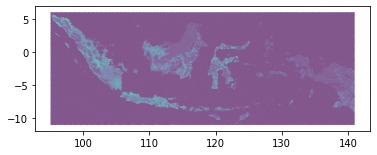

In [7]:
# We do the check using  rubber production as its one of the datases that we use
resolution = 6
raster_path = output_folder+ '/rubber_production_clip.tif'
with rio.open(raster_path) as src:
    gdf = raster.raster_to_geodataframe(src.read(1), src.transform, h3_resolution=resolution, nodata_value=src.profile['nodata'], compacted=False)

    gdf.plot('value')
    gdf['h3index'] = gdf['h3index'].apply(hex)

In [8]:
## explore and export gdf to shapefile so we can compare the cliped raster and raster in qgis
gdf

,h3index,value,geometry
0,0x8668c8597ffffff,34.782089,"POLYGON ((124.49162 0.90373, 124.48635 0.86855..."
1,0x8668c859fffffff,34.782089,"POLYGON ((124.55117 0.89344, 124.54590 0.85825..."
2,0x868d89397ffffff,122.192039,"POLYGON ((108.49672 -6.98087, 108.50052 -6.947..."
3,0x869cda017ffffff,41.972240,"POLYGON ((139.62853 -5.39322, 139.62225 -5.428..."
4,0x869cda01fffffff,41.972240,"POLYGON ((139.56639 -5.38286, 139.56012 -5.418..."
...,...,...,...
248788,0x868caa21fffffff,80.189461,"POLYGON ((105.59712 -2.94820, 105.60074 -2.913..."
248789,0x868caa2e7ffffff,80.189461,"POLYGON ((105.53681 -2.94423, 105.54042 -2.909..."
248790,0x86956a1b7ffffff,26.987938,"POLYGON ((128.38310 -3.15169, 128.37752 -3.186..."
248791,0x86956accfffffff,26.987938,"POLYGON ((128.34433 -3.19879, 128.33876 -3.233..."


In [8]:
#remove the first part to be able of merging with the additional dataset from the db
updated_index = [index.split('x')[1] for index in list(gdf['h3index'])]
gdf['h3index']=updated_index
gdf.head()

,h3index,value,geometry
0,86689486fffffff,36.700630,"POLYGON ((112.49270 -0.82687, 112.49687 -0.792..."
1,8668b3497ffffff,36.700630,"POLYGON ((112.47028 -0.77371, 112.47445 -0.739..."
2,868cd6b27ffffff,173.292496,"POLYGON ((102.49214 -1.47385, 102.49548 -1.438..."
3,868d85ca7ffffff,171.259506,"POLYGON ((112.70188 -7.83682, 112.70597 -7.804..."
4,868d85cb7ffffff,171.259506,"POLYGON ((112.73598 -7.78970, 112.74007 -7.757..."


In [14]:
#save to file so we can explore in qgis
gdf.to_file(output_folder+ '/h3_rubber_production_clip.shp')

In [12]:
# retrieve what we have in the ddbb to compare results
ddbb_database = pd.read_sql_query("""select prod.h3index, prod."earthstat2000GlobalRubberProduction" from h3_grid_earthstat2000_global_prod prod""" , conn)
ddbb_database.head()

,h3index,earthstat2000GlobalRubberProduction
0,86f2166dfffffff,NaN
1,86f2166e7ffffff,NaN
2,86f2166efffffff,NaN
3,86f2166f7ffffff,NaN
4,86f216707ffffff,NaN


In [20]:
merged_gdf = gdf.merge(ddbb_database, how='inner', on='h3index')
merged_gdf.head()

,h3index,value,geometry,earthstat2000GlobalRubberProduction
0,8668c8597ffffff,34.782089,"POLYGON ((124.49162 0.90373, 124.48635 0.86855...",34.78209
1,8668c859fffffff,34.782089,"POLYGON ((124.55117 0.89344, 124.54590 0.85825...",34.78209
2,868d89397ffffff,122.192039,"POLYGON ((108.49672 -6.98087, 108.50052 -6.947...",122.19204
3,869cda017ffffff,41.972240,"POLYGON ((139.62853 -5.39322, 139.62225 -5.428...",41.97224
4,869cda01fffffff,41.972240,"POLYGON ((139.56639 -5.38286, 139.56012 -5.418...",41.97224


In [21]:
## as we can see all the values are particularly the same between the conversion in the local file and the database
merged_gdf

,h3index,value,geometry,earthstat2000GlobalRubberProduction
0,8668c8597ffffff,34.782089,"POLYGON ((124.49162 0.90373, 124.48635 0.86855...",34.782090
1,8668c859fffffff,34.782089,"POLYGON ((124.55117 0.89344, 124.54590 0.85825...",34.782090
2,868d89397ffffff,122.192039,"POLYGON ((108.49672 -6.98087, 108.50052 -6.947...",122.192040
3,869cda017ffffff,41.972240,"POLYGON ((139.62853 -5.39322, 139.62225 -5.428...",41.972240
4,869cda01fffffff,41.972240,"POLYGON ((139.56639 -5.38286, 139.56012 -5.418...",41.972240
...,...,...,...,...
248422,868caa21fffffff,80.189461,"POLYGON ((105.59712 -2.94820, 105.60074 -2.913...",80.189460
248423,868caa2e7ffffff,80.189461,"POLYGON ((105.53681 -2.94423, 105.54042 -2.909...",80.189460
248424,86956a1b7ffffff,26.987938,"POLYGON ((128.38310 -3.15169, 128.37752 -3.186...",26.987938
248425,86956accfffffff,26.987938,"POLYGON ((128.34433 -3.19879, 128.33876 -3.233...",26.987938


In [24]:
#export to csv so we can compare in the excel spreadhseet
merged_gdf.to_csv(output_folder+ '/h3_rubber_production_clip.csv')

# 2. Check total production in different locations and data import - Rubber:

In [26]:
df_rubber = gpd.GeoDataFrame.from_postgis("""SELECT sr.id, sr.tonnage, ir."scaler", sr."year", gr."name" as loc, gr."theGeom", m."name" , sl."locationType" FROM sourcing_records sr 
    INNER JOIN sourcing_location sl on sl.id=sr."sourcingLocationId" 
    INNER JOIN material m on m.id=sl."materialId" 
    INNER JOIN geo_region gr on gr.id =sl."geoRegionId" 
    INNER JOIN indicator_record ir on ir."sourcingRecordId"= sr.id
    WHERE m."name" = 'Rubber and articles thereof' and ir."indicatorId"='633cf928-7c4f-41a3-99c5-e8c1bda0b323'""", conn, geom_col='theGeom')
df_rubber

,id,tonnage,scaler,year,loc,theGeom,name,locationType
0,6b20df8b-00ca-4a12-86c5-d9314d9cca86,2400.0,9.364061e-39,2010,LBN,"MULTIPOLYGON (((35.81722 33.36403, 35.81616 33...",Rubber and articles thereof,unknown
1,0cfb24b9-cc1d-411c-9a77-18b4232e5453,2424.0,9.364061e-39,2011,LBN,"MULTIPOLYGON (((35.81722 33.36403, 35.81616 33...",Rubber and articles thereof,unknown
2,dec5f7af-f922-418c-926a-037b795f3eab,2448.0,9.364061e-39,2012,LBN,"MULTIPOLYGON (((35.81722 33.36403, 35.81616 33...",Rubber and articles thereof,unknown
3,bbe7e85d-3cf4-490a-a868-23ed9a949619,2472.0,9.364061e-39,2013,LBN,"MULTIPOLYGON (((35.81722 33.36403, 35.81616 33...",Rubber and articles thereof,unknown
4,9e20a995-1f0f-49f8-958f-81391da61bc5,2497.0,9.364061e-39,2014,LBN,"MULTIPOLYGON (((35.81722 33.36403, 35.81616 33...",Rubber and articles thereof,unknown
...,...,...,...,...,...,...,...,...
270,9f3dfcc1-8696-465f-8cf8-604ac543986c,380.0,3.563344e+02,2016,77135778,POINT (-9.04000 5.01000),Rubber and articles thereof,point of production
271,e7dadacc-09d5-4215-bac0-89f1354483f7,384.0,3.563344e+02,2017,77135778,POINT (-9.04000 5.01000),Rubber and articles thereof,point of production
272,14d1256e-6993-424f-99b8-422aba062ac5,388.0,3.563344e+02,2018,77135778,POINT (-9.04000 5.01000),Rubber and articles thereof,point of production
273,0c8350b8-f3db-4d91-9993-e71681a9145a,392.0,3.563344e+02,2019,77135778,POINT (-9.04000 5.01000),Rubber and articles thereof,point of production


<AxesSubplot:>

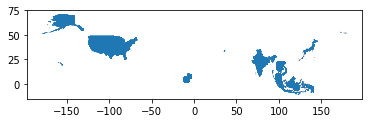

In [53]:
df_rubber.plot()


In [18]:
raster_path = '../../datasets/raw/qa_values/rubber_HarvAreaYield_Geotiff/rubber_Production.tif'
raster_stats = []
for i, row in df_rubber.iterrows():
    geom = row['theGeom']
    stat_ = zonal_stats(geom,
                raster_path,
                stats='sum',
                all_touched = True
            )
    raster_stats.append(stat_[0]['sum'])
    
df_rubber['raster_stats_prod']=raster_stats
df_rubber.head()


/opt/conda/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


,id,tonnage,scaler,year,loc,theGeom,name,locationType,raster_stats_prod
0,6b20df8b-00ca-4a12-86c5-d9314d9cca86,2400.0,9.364061e-39,2010,LBN,"MULTIPOLYGON (((35.81722 33.36403, 35.81616 33...",Rubber and articles thereof,unknown,5.989563e-39
1,0cfb24b9-cc1d-411c-9a77-18b4232e5453,2424.0,9.364061e-39,2011,LBN,"MULTIPOLYGON (((35.81722 33.36403, 35.81616 33...",Rubber and articles thereof,unknown,5.989563e-39
2,dec5f7af-f922-418c-926a-037b795f3eab,2448.0,9.364061e-39,2012,LBN,"MULTIPOLYGON (((35.81722 33.36403, 35.81616 33...",Rubber and articles thereof,unknown,5.989563e-39
3,bbe7e85d-3cf4-490a-a868-23ed9a949619,2472.0,9.364061e-39,2013,LBN,"MULTIPOLYGON (((35.81722 33.36403, 35.81616 33...",Rubber and articles thereof,unknown,5.989563e-39
4,9e20a995-1f0f-49f8-958f-81391da61bc5,2497.0,9.364061e-39,2014,LBN,"MULTIPOLYGON (((35.81722 33.36403, 35.81616 33...",Rubber and articles thereof,unknown,5.989563e-39


In [20]:
df_rubber.to_csv('../../datasets/raw/qa_values/rubber_qa/production_db_raster_v2.csv')

In [16]:
# we have the same values on the ddbb but as we can see from this results and the ones that we have on the table above
# we are overestimating the impact
sourcing_records = pd.read_sql_query(
    SQL_SUM_MATERIAL_OVER_GEO_REGION \
    + """
    SELECT
        sr.id,
        sr.tonnage,
        sr.year,
        sl.id,
        sl.production,
        sl."materialId"
    FROM
        sourcing_records sr
        INNER JOIN
            (
                SELECT
                    id,
                    "materialId",
                    sum_material_over_georegion("geoRegionId", "materialId", 'producer') as production
                FROM
                    sourcing_location
            ) as sl
            on sr."sourcingLocationId" = sl.id
    WHERE sl."materialId"='0d7b1be5-dc86-47b8-ba3a-25190a275011'
""", conn)
sourcing_records

,id,tonnage,year,id,production,materialId
0,6b20df8b-00ca-4a12-86c5-d9314d9cca86,2400.0,2010,955cde11-fa48-4881-a0d4-7dbf896b1140,9.364061e-39,0d7b1be5-dc86-47b8-ba3a-25190a275011
1,0cfb24b9-cc1d-411c-9a77-18b4232e5453,2424.0,2011,955cde11-fa48-4881-a0d4-7dbf896b1140,9.364061e-39,0d7b1be5-dc86-47b8-ba3a-25190a275011
2,dec5f7af-f922-418c-926a-037b795f3eab,2448.0,2012,955cde11-fa48-4881-a0d4-7dbf896b1140,9.364061e-39,0d7b1be5-dc86-47b8-ba3a-25190a275011
3,bbe7e85d-3cf4-490a-a868-23ed9a949619,2472.0,2013,955cde11-fa48-4881-a0d4-7dbf896b1140,9.364061e-39,0d7b1be5-dc86-47b8-ba3a-25190a275011
4,9e20a995-1f0f-49f8-958f-81391da61bc5,2497.0,2014,955cde11-fa48-4881-a0d4-7dbf896b1140,9.364061e-39,0d7b1be5-dc86-47b8-ba3a-25190a275011
...,...,...,...,...,...,...
270,9f3dfcc1-8696-465f-8cf8-604ac543986c,380.0,2016,d24d4feb-c271-4a63-a8f9-1cb6f913b1ec,3.563344e+02,0d7b1be5-dc86-47b8-ba3a-25190a275011
271,e7dadacc-09d5-4215-bac0-89f1354483f7,384.0,2017,d24d4feb-c271-4a63-a8f9-1cb6f913b1ec,3.563344e+02,0d7b1be5-dc86-47b8-ba3a-25190a275011
272,14d1256e-6993-424f-99b8-422aba062ac5,388.0,2018,d24d4feb-c271-4a63-a8f9-1cb6f913b1ec,3.563344e+02,0d7b1be5-dc86-47b8-ba3a-25190a275011
273,0c8350b8-f3db-4d91-9993-e71681a9145a,392.0,2019,d24d4feb-c271-4a63-a8f9-1cb6f913b1ec,3.563344e+02,0d7b1be5-dc86-47b8-ba3a-25190a275011


As we can see between the production values on the ddbb and the production values obtained with the raster stadistics, we are overestimating the production values. This may generate so really impact values. 

We can try to mitigate this overestimation by:

- ingesting the data as density
- identifying equal values in the h3 data so we remove the double counting

## a- identify equal values and remove them directly in the ddbb

Test a particular area:

- georegion_id = '13211da6-bbaa-497c-9a9e-abd3bc9856ac'
- commodity = rubber



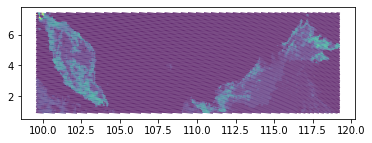

In [26]:
# We do the check using  rubber production as its one of the datases that we use
resolution = 6
raster_path = output_folder+ '/rubber_production_clipped_malaysia.tif'
with rio.open(raster_path) as src:
    gdf = raster.raster_to_geodataframe(src.read(1), src.transform, h3_resolution=resolution, nodata_value=src.profile['nodata'], compacted=False)

    gdf.plot('value')
    gdf['h3index'] = gdf['h3index'].apply(hex)

In [27]:
gdf

,h3index,value,geometry
0,0x8668ab887ffffff,24.902800,"POLYGON ((116.98843 2.13565, 116.98393 2.10174..."
1,0x8668ab88fffffff,24.902800,"POLYGON ((117.04355 2.12632, 117.03904 2.09239..."
2,0x8668ab8afffffff,24.902800,"POLYGON ((117.02275 2.18186, 117.01824 2.14794..."
3,0x86651c687ffffff,331.718414,"POLYGON ((101.34943 6.53013, 101.35275 6.56656..."
4,0x86651c68fffffff,331.718414,"POLYGON ((101.28609 6.53551, 101.28940 6.57195..."
...,...,...,...
40240,0x8668aeac7ffffff,18.515448,"POLYGON ((115.87721 2.65740, 115.88163 2.69139..."
40241,0x8668aeacfffffff,18.515448,"POLYGON ((115.93295 2.65204, 115.93737 2.68602..."
40242,0x8668aeaefffffff,18.515448,"POLYGON ((115.91171 2.70570, 115.91614 2.73969..."
40243,0x8668aba07ffffff,102.964363,"POLYGON ((117.42322 2.21846, 117.41867 2.18445..."


In [28]:
# expor to shp
gdf.to_file(output_folder+ '/h3_rubber_production_clip_malaysia_v2.shp')

In [30]:
# sum material over georegion
#get_h3_table_column_for_material
#sum_h3_grid_over_georegion
sourcing_records_test_location = pd.read_sql_query("""SELECT h3_uncompact(gr."h3Compact"::h3index[], 6)  h3index 
FROM geo_region gr 
WHERE gr.id = '13211da6-bbaa-497c-9a9e-abd3bc9856ac'""", conn)
sourcing_records_test_location

,h3index
0,866523c17ffffff
1,8665206c7ffffff
2,86652290fffffff
3,866520597ffffff
4,86652060fffffff
...,...
228,866522b97ffffff
229,866522b9fffffff
230,866522ba7ffffff
231,866522bafffffff


In [34]:
#clean h3indexes before the joining

clean_index_list = [el.split('x')[1] for el in list(gdf['h3index'])]
gdf['h3index'] = clean_index_list
gdf

,h3index,value,geometry
0,8668ab887ffffff,24.902800,"POLYGON ((116.98843 2.13565, 116.98393 2.10174..."
1,8668ab88fffffff,24.902800,"POLYGON ((117.04355 2.12632, 117.03904 2.09239..."
2,8668ab8afffffff,24.902800,"POLYGON ((117.02275 2.18186, 117.01824 2.14794..."
3,86651c687ffffff,331.718414,"POLYGON ((101.34943 6.53013, 101.35275 6.56656..."
4,86651c68fffffff,331.718414,"POLYGON ((101.28609 6.53551, 101.28940 6.57195..."
...,...,...,...
40240,8668aeac7ffffff,18.515448,"POLYGON ((115.87721 2.65740, 115.88163 2.69139..."
40241,8668aeacfffffff,18.515448,"POLYGON ((115.93295 2.65204, 115.93737 2.68602..."
40242,8668aeaefffffff,18.515448,"POLYGON ((115.91171 2.70570, 115.91614 2.73969..."
40243,8668aba07ffffff,102.964363,"POLYGON ((117.42322 2.21846, 117.41867 2.18445..."


In [36]:
#inner join both datasets
sourcing_record_malaysia = sourcing_records_test_location.merge(gdf,
    how='inner',
    on='h3index')
sourcing_record_malaysia

,h3index,value,geometry
0,866523c17ffffff,323.403351,"POLYGON ((102.92540 2.08357, 102.92883 2.11937..."
1,8665206c7ffffff,413.426605,"POLYGON ((102.95663 1.75680, 102.96006 1.79254..."
2,86652290fffffff,226.628906,"POLYGON ((103.80822 1.85149, 103.81173 1.88717..."
3,866520597ffffff,608.002319,"POLYGON ((103.69974 1.69830, 103.70324 1.73396..."
4,86652060fffffff,0.000000,"POLYGON ((103.00836 1.64477, 103.01179 1.68049..."
...,...,...,...
228,866522b97ffffff,515.337463,"POLYGON ((103.51982 2.09039, 103.52330 2.12614..."
229,866522b9fffffff,515.337463,"POLYGON ((103.45787 2.09533, 103.46135 2.13108..."
230,866522ba7ffffff,445.505829,"POLYGON ((103.50937 1.98318, 103.51285 2.01891..."
231,866522bafffffff,445.505829,"POLYGON ((103.44744 1.98810, 103.45092 2.02384..."


In [40]:
#sum value 
# value in ddbb - 93031,484375000000000
#raster value - 50676,230468750000000
sum(sourcing_record_malaysia['value'])

93031.47853851318

In [43]:
# sum just unique values
sum(sourcing_record_malaysia['value'].unique())

47332.78470611572

In [46]:
test = pd.read_sql_query("""select u.prod from
(select prodtable."earthstat2000GlobalRubberProduction" as prod
from 
(select h3_uncompact(gr."h3Compact"::h3index[], 6)  h3index from geo_region gr where gr.id = '13211da6-bbaa-497c-9a9e-abd3bc9856ac') t
inner join  h3_grid_earthstat2000_global_prod prodtable on prodtable.h3index = t.h3index ) u
where u.prod > 0""", conn)
test

,prod
0,323.40335
1,413.42660
2,226.62890
3,608.00230
4,613.09720
...,...
218,515.33746
219,515.33746
220,445.50583
221,445.50583


In [50]:
sum(test['prod'])

93031.47844499991

In [49]:
sum(test['prod'].unique())

47332.78464

It seems that summing unique values we are getting better results - try to do the same for all the sourcing regions on the ddbb and export to excel spreadhseet so we can compare against previous results.



In [37]:
# define functions with distincts

SQL_GET_H3_UNCOMPACT_GEO_REGION = """
CREATE OR REPLACE FUNCTION get_h3_uncompact_geo_region(geo_region_id uuid, h3_resolution int)
RETURNS TABLE (h3index h3index) AS 
$$
    SELECT h3_uncompact(geo_region."h3Compact"::h3index[], h3_resolution) h3index
    FROM geo_region WHERE geo_region.id = geo_region_id
$$ 
LANGUAGE SQL;
"""

SQL_SUM_H3_GRID_OVER_GEO_REGION = SQL_GET_H3_UNCOMPACT_GEO_REGION+"""
CREATE OR REPLACE FUNCTION sum_h3_grid_over_georegion(
    geo_region_id uuid, 
    h3_resolution int,
    h3_table_name varchar, 
    h3_column_name varchar
)
RETURNS float AS
$$
    DECLARE 
        sum float;
    BEGIN
        EXECUTE format (
            'SELECT sum(u.val)
                FROM
                    (SELECT 
                        h3grid.%I::float as val
                    FROM
                        get_h3_uncompact_geo_region($1, $2) geo_region
                        INNER JOIN %I h3grid ON h3grid.h3index = geo_region.h3index
                        GROUP BY h3grid.%I) u
                WHERE u.val > 0;
            ', h3_column_name, h3_table_name, h3_column_name)
            USING geo_region_id, h3_resolution
            INTO sum;
        RETURN sum;
    END;
$$
LANGUAGE plpgsql;
"""

SQL_GET_H3_TABLE_COLUMN_FOR_MATERIAL = """
CREATE OR REPLACE FUNCTION get_h3_table_column_for_material(material_id uuid, h3_data_type material_to_h3_type_enum)
RETURNS TABLE (h3_table_name varchar, h3_column_name varchar, h3_resolution int) AS
$$
    SELECT h3_data."h3tableName", h3_data."h3columnName", h3_data."h3resolution"
    FROM h3_data
        INNER JOIN material_to_h3 ON material_to_h3."h3DataId" = h3_data.id
    WHERE material_to_h3."materialId" = material_id 
        AND material_to_h3.type = h3_data_type
    LIMIT 1;
$$
LANGUAGE SQL;
"""

SQL_SUM_DISTINCT_MATERIAL_OVER_GEO_REGION = SQL_SUM_H3_GRID_OVER_GEO_REGION+SQL_GET_H3_TABLE_COLUMN_FOR_MATERIAL+"""
CREATE OR REPLACE FUNCTION sum_distinct_material_over_georegion(
    geo_region_id uuid, 
    material_id uuid,
    h3_data_type material_to_h3_type_enum
)
RETURNS float AS
$$
    DECLARE
        h3_table_name varchar;
        h3_column_name varchar;
        h3_resolution integer;
        sum float;

    BEGIN
        -- Get h3data table name and column name for given material
        SELECT * INTO h3_table_name, h3_column_name, h3_resolution
        FROM get_h3_table_column_for_material(material_id, h3_data_type);

        -- Sum table column over region
        SELECT sum_h3_grid_over_georegion(geo_region_id, h3_resolution, h3_table_name, h3_column_name) 
        INTO sum;
        RETURN sum;
    END;
$$
LANGUAGE plpgsql;
"""

SQL_SUM_DISTINCT_WEIGHTED_DEFORESTATION_OVER_GEO_REGION = """
CREATE OR REPLACE FUNCTION sum_distinct_weighted_deforestation_over_georegion(
    geo_region_id uuid, 
    material_id uuid,
    h3_data_type material_to_h3_type_enum
)
RETURNS float AS
$$
    DECLARE
        material_h3_table_name varchar;
        material_h3_column_name varchar;
        h3_resolution integer;
        deforestation_h3_table_name varchar := 'h3_grid_deforestation_global';
        deforestation_h3_column_name varchar := 'hansenLoss2019';
        sum float;

    BEGIN
        -- Get h3data table name and column name for given material
        SELECT * INTO material_h3_table_name, material_h3_column_name, h3_resolution
        FROM get_h3_table_column_for_material(material_id, h3_data_type);

        -- Sum table column over region
        EXECUTE format(
            'SELECT sum(u.defImpc) FROM
                (SELECT h3grid_mat.%I * h3grid_def.%I as defImpc
                    FROM
                        get_h3_uncompact_geo_region($1, $2) geo_region
                        INNER JOIN %I h3grid_mat ON h3grid_mat.h3index = geo_region.h3index
                        INNER JOIN %I h3grid_def ON h3grid_def.h3index = geo_region.h3index
                    GROUP BY defImpc) u
            WHERE u.defImpc > 0;
            ', material_h3_column_name, deforestation_h3_column_name, material_h3_table_name, deforestation_h3_table_name)
            USING geo_region_id, h3_resolution
            INTO sum;
        RETURN sum;
    END;
$$
LANGUAGE plpgsql;
"""

In [66]:
sourcing_records_distinct = pd.read_sql_query(
    SQL_SUM_MATERIAL_OVER_GEO_REGION \
    + """
    SELECT
        sr.id,
        sr.tonnage,
        sr.year,
        sl.id,
        sl.production,
        sl."materialId"
    FROM
        sourcing_records sr
        INNER JOIN
            (
                SELECT
                    id,
                    "materialId",
                    sum_material_over_georegion("geoRegionId", "materialId", 'producer') as production
                FROM
                    sourcing_location
            ) as sl
            on sr."sourcingLocationId" = sl.id
    WHERE sl."materialId"='0d7b1be5-dc86-47b8-ba3a-25190a275011'
""", conn)
sourcing_records_distinct

,id,tonnage,year,id,production,materialId
0,6b20df8b-00ca-4a12-86c5-d9314d9cca86,2400.0,2010,955cde11-fa48-4881-a0d4-7dbf896b1140,5.475783e-39,0d7b1be5-dc86-47b8-ba3a-25190a275011
1,0cfb24b9-cc1d-411c-9a77-18b4232e5453,2424.0,2011,955cde11-fa48-4881-a0d4-7dbf896b1140,5.475783e-39,0d7b1be5-dc86-47b8-ba3a-25190a275011
2,dec5f7af-f922-418c-926a-037b795f3eab,2448.0,2012,955cde11-fa48-4881-a0d4-7dbf896b1140,5.475783e-39,0d7b1be5-dc86-47b8-ba3a-25190a275011
3,bbe7e85d-3cf4-490a-a868-23ed9a949619,2472.0,2013,955cde11-fa48-4881-a0d4-7dbf896b1140,5.475783e-39,0d7b1be5-dc86-47b8-ba3a-25190a275011
4,9e20a995-1f0f-49f8-958f-81391da61bc5,2497.0,2014,955cde11-fa48-4881-a0d4-7dbf896b1140,5.475783e-39,0d7b1be5-dc86-47b8-ba3a-25190a275011
...,...,...,...,...,...,...
270,9f3dfcc1-8696-465f-8cf8-604ac543986c,380.0,2016,d24d4feb-c271-4a63-a8f9-1cb6f913b1ec,3.563344e+02,0d7b1be5-dc86-47b8-ba3a-25190a275011
271,e7dadacc-09d5-4215-bac0-89f1354483f7,384.0,2017,d24d4feb-c271-4a63-a8f9-1cb6f913b1ec,3.563344e+02,0d7b1be5-dc86-47b8-ba3a-25190a275011
272,14d1256e-6993-424f-99b8-422aba062ac5,388.0,2018,d24d4feb-c271-4a63-a8f9-1cb6f913b1ec,3.563344e+02,0d7b1be5-dc86-47b8-ba3a-25190a275011
273,0c8350b8-f3db-4d91-9993-e71681a9145a,392.0,2019,d24d4feb-c271-4a63-a8f9-1cb6f913b1ec,3.563344e+02,0d7b1be5-dc86-47b8-ba3a-25190a275011


In [67]:
#export to csv
sourcing_records_distinct.to_csv('../../datasets/raw/qa_values/rubber_qa/production_db_raster_distinct_v1.csv')

# 3. Check total harvest area in different locations and data import - Rubber:

In [78]:
#obtain harvest area from the database
sourcing_records_harvest = pd.read_sql_query(
    SQL_SUM_MATERIAL_OVER_GEO_REGION \
    + """
    SELECT
        sr.id,
        sr.tonnage,
        sr.year,
        sl.id,
        sl.harvest,
        sl."materialId"
    FROM
        sourcing_records sr
        INNER JOIN
            (
                SELECT
                    id,
                    "materialId",
                    sum_material_over_georegion("geoRegionId", "materialId", 'harvest') as harvest
                FROM
                    sourcing_location
            ) as sl
            on sr."sourcingLocationId" = sl.id
    WHERE sl."materialId"='0d7b1be5-dc86-47b8-ba3a-25190a275011'
""", conn)
sourcing_records_harvest

,id,tonnage,year,id,harvest,materialId
0,6b20df8b-00ca-4a12-86c5-d9314d9cca86,2400.0,2010,955cde11-fa48-4881-a0d4-7dbf896b1140,1.745669e-17,0d7b1be5-dc86-47b8-ba3a-25190a275011
1,0cfb24b9-cc1d-411c-9a77-18b4232e5453,2424.0,2011,955cde11-fa48-4881-a0d4-7dbf896b1140,1.745669e-17,0d7b1be5-dc86-47b8-ba3a-25190a275011
2,dec5f7af-f922-418c-926a-037b795f3eab,2448.0,2012,955cde11-fa48-4881-a0d4-7dbf896b1140,1.745669e-17,0d7b1be5-dc86-47b8-ba3a-25190a275011
3,bbe7e85d-3cf4-490a-a868-23ed9a949619,2472.0,2013,955cde11-fa48-4881-a0d4-7dbf896b1140,1.745669e-17,0d7b1be5-dc86-47b8-ba3a-25190a275011
4,9e20a995-1f0f-49f8-958f-81391da61bc5,2497.0,2014,955cde11-fa48-4881-a0d4-7dbf896b1140,1.745669e-17,0d7b1be5-dc86-47b8-ba3a-25190a275011
...,...,...,...,...,...,...
270,9f3dfcc1-8696-465f-8cf8-604ac543986c,380.0,2016,d24d4feb-c271-4a63-a8f9-1cb6f913b1ec,3.708378e+02,0d7b1be5-dc86-47b8-ba3a-25190a275011
271,e7dadacc-09d5-4215-bac0-89f1354483f7,384.0,2017,d24d4feb-c271-4a63-a8f9-1cb6f913b1ec,3.708378e+02,0d7b1be5-dc86-47b8-ba3a-25190a275011
272,14d1256e-6993-424f-99b8-422aba062ac5,388.0,2018,d24d4feb-c271-4a63-a8f9-1cb6f913b1ec,3.708378e+02,0d7b1be5-dc86-47b8-ba3a-25190a275011
273,0c8350b8-f3db-4d91-9993-e71681a9145a,392.0,2019,d24d4feb-c271-4a63-a8f9-1cb6f913b1ec,3.708378e+02,0d7b1be5-dc86-47b8-ba3a-25190a275011


In [71]:
#zonal statistics for each location and the raster
df_rubber.head()

,id,tonnage,scaler,year,loc,theGeom,name,locationType,raster_stats_prod
0,6b20df8b-00ca-4a12-86c5-d9314d9cca86,2400.0,9.364061e-39,2010,LBN,"MULTIPOLYGON (((35.81722 33.36403, 35.81616 33...",Rubber and articles thereof,unknown,5.989563e-39
1,0cfb24b9-cc1d-411c-9a77-18b4232e5453,2424.0,9.364061e-39,2011,LBN,"MULTIPOLYGON (((35.81722 33.36403, 35.81616 33...",Rubber and articles thereof,unknown,5.989563e-39
2,dec5f7af-f922-418c-926a-037b795f3eab,2448.0,9.364061e-39,2012,LBN,"MULTIPOLYGON (((35.81722 33.36403, 35.81616 33...",Rubber and articles thereof,unknown,5.989563e-39
3,bbe7e85d-3cf4-490a-a868-23ed9a949619,2472.0,9.364061e-39,2013,LBN,"MULTIPOLYGON (((35.81722 33.36403, 35.81616 33...",Rubber and articles thereof,unknown,5.989563e-39
4,9e20a995-1f0f-49f8-958f-81391da61bc5,2497.0,9.364061e-39,2014,LBN,"MULTIPOLYGON (((35.81722 33.36403, 35.81616 33...",Rubber and articles thereof,unknown,5.989563e-39


In [79]:
raster_path = '../../datasets/raw/qa_values/rubber_HarvAreaYield_Geotiff/rubber_HarvestedAreaHectares.tif'
raster_stats = []
for i, row in df_rubber.iterrows():
    geom = row['theGeom']
    stat_ = zonal_stats(geom,
                raster_path,
                stats='sum',
                all_touched = True
            )
    raster_stats.append(stat_[0]['sum'])
    
sourcing_records_harvest['raster_stats_prod']=raster_stats
sourcing_records_harvest.head()


/opt/conda/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


,id,tonnage,year,id,harvest,materialId,raster_stats_prod
0,6b20df8b-00ca-4a12-86c5-d9314d9cca86,2400.0,2010,955cde11-fa48-4881-a0d4-7dbf896b1140,1.745669e-17,0d7b1be5-dc86-47b8-ba3a-25190a275011,1.094765e-17
1,0cfb24b9-cc1d-411c-9a77-18b4232e5453,2424.0,2011,955cde11-fa48-4881-a0d4-7dbf896b1140,1.745669e-17,0d7b1be5-dc86-47b8-ba3a-25190a275011,1.094765e-17
2,dec5f7af-f922-418c-926a-037b795f3eab,2448.0,2012,955cde11-fa48-4881-a0d4-7dbf896b1140,1.745669e-17,0d7b1be5-dc86-47b8-ba3a-25190a275011,1.094765e-17
3,bbe7e85d-3cf4-490a-a868-23ed9a949619,2472.0,2013,955cde11-fa48-4881-a0d4-7dbf896b1140,1.745669e-17,0d7b1be5-dc86-47b8-ba3a-25190a275011,1.094765e-17
4,9e20a995-1f0f-49f8-958f-81391da61bc5,2497.0,2014,955cde11-fa48-4881-a0d4-7dbf896b1140,1.745669e-17,0d7b1be5-dc86-47b8-ba3a-25190a275011,1.094765e-17


In [81]:
#calculate the values using yje distinct
#obtain harvest area from the database
sourcing_records_harvest_distinct = pd.read_sql_query(
    SQL_SUM_MATERIAL_OVER_GEO_REGION \
    + """
    SELECT
        sr.id,
        sr.tonnage,
        sr.year,
        sl.id,
        sl.harvest,
        sl."materialId"
    FROM
        sourcing_records sr
        INNER JOIN
            (
                SELECT
                    id,
                    "materialId",
                    sum_material_over_georegion("geoRegionId", "materialId", 'harvest') as harvest
                FROM
                    sourcing_location
            ) as sl
            on sr."sourcingLocationId" = sl.id
    WHERE sl."materialId"='0d7b1be5-dc86-47b8-ba3a-25190a275011'
""", conn)
sourcing_records_harvest_distinct

,id,tonnage,year,id,harvest,materialId
0,6b20df8b-00ca-4a12-86c5-d9314d9cca86,2400.0,2010,955cde11-fa48-4881-a0d4-7dbf896b1140,1.033730e-17,0d7b1be5-dc86-47b8-ba3a-25190a275011
1,0cfb24b9-cc1d-411c-9a77-18b4232e5453,2424.0,2011,955cde11-fa48-4881-a0d4-7dbf896b1140,1.033730e-17,0d7b1be5-dc86-47b8-ba3a-25190a275011
2,dec5f7af-f922-418c-926a-037b795f3eab,2448.0,2012,955cde11-fa48-4881-a0d4-7dbf896b1140,1.033730e-17,0d7b1be5-dc86-47b8-ba3a-25190a275011
3,bbe7e85d-3cf4-490a-a868-23ed9a949619,2472.0,2013,955cde11-fa48-4881-a0d4-7dbf896b1140,1.033730e-17,0d7b1be5-dc86-47b8-ba3a-25190a275011
4,9e20a995-1f0f-49f8-958f-81391da61bc5,2497.0,2014,955cde11-fa48-4881-a0d4-7dbf896b1140,1.033730e-17,0d7b1be5-dc86-47b8-ba3a-25190a275011
...,...,...,...,...,...,...
270,9f3dfcc1-8696-465f-8cf8-604ac543986c,380.0,2016,d24d4feb-c271-4a63-a8f9-1cb6f913b1ec,3.708378e+02,0d7b1be5-dc86-47b8-ba3a-25190a275011
271,e7dadacc-09d5-4215-bac0-89f1354483f7,384.0,2017,d24d4feb-c271-4a63-a8f9-1cb6f913b1ec,3.708378e+02,0d7b1be5-dc86-47b8-ba3a-25190a275011
272,14d1256e-6993-424f-99b8-422aba062ac5,388.0,2018,d24d4feb-c271-4a63-a8f9-1cb6f913b1ec,3.708378e+02,0d7b1be5-dc86-47b8-ba3a-25190a275011
273,0c8350b8-f3db-4d91-9993-e71681a9145a,392.0,2019,d24d4feb-c271-4a63-a8f9-1cb6f913b1ec,3.708378e+02,0d7b1be5-dc86-47b8-ba3a-25190a275011


In [83]:
sourcing_records_harvest['distict_harvest'] = list(sourcing_records_harvest_distinct['harvest'])

In [84]:
# export to csv  so we can compare in excel spreadhseet
sourcing_records_harvest.to_csv('../../datasets/raw/qa_values/rubber_qa/harvest_db_raster_distinct_v1.csv')

# 4. Check deforestation impact in different locations and data import - Rubber:

In [105]:
#obtain deforestation from the database
sourcing_records_deforestation = pd.read_sql_query(
    SQL_SUM_MATERIAL_OVER_GEO_REGION \
    +SQL_SUM_WEIGHTED_DEFORESTATION_OVER_GEO_REGION \
    + """
    SELECT
        sr.id,
        sr.tonnage,
        sr.year,
        sl.id,
        sl.production,
        sl.harvest,
        sl.raw_deforestation,
        sl."materialId"
    FROM
        sourcing_records sr
        INNER JOIN
            (
                SELECT
                    id,
                    "materialId",
                    sum_material_over_georegion("geoRegionId", "materialId", 'producer') as production,
                    sum_material_over_georegion("geoRegionId", "materialId", 'harvest') as harvest,
                    sum_weighted_deforestation_over_georegion("geoRegionId", "materialId", 'harvest') as raw_deforestation
                FROM
                    sourcing_location
            ) as sl
            on sr."sourcingLocationId" = sl.id
    WHERE sl."materialId"='0d7b1be5-dc86-47b8-ba3a-25190a275011'
""", conn)

sourcing_records_deforestation['land_per_ton'] = sourcing_records_deforestation['harvest'] / sourcing_records_deforestation['production']

sourcing_records_deforestation['deforestation_per_ha_landuse'] = sourcing_records_deforestation['raw_deforestation'] / sourcing_records_deforestation['harvest']
sourcing_records_deforestation['land_use'] = sourcing_records_deforestation['land_per_ton'] * sourcing_records_deforestation['tonnage']

sourcing_records_deforestation['deforestation'] = sourcing_records_deforestation['deforestation_per_ha_landuse'] * sourcing_records_deforestation['land_use']

sourcing_records_deforestation.head()



,id,tonnage,year,id,production,harvest,raw_deforestation,materialId,land_per_ton,deforestation_per_ha_landuse,land_use,deforestation
0,6b20df8b-00ca-4a12-86c5-d9314d9cca86,2400.0,2010,955cde11-fa48-4881-a0d4-7dbf896b1140,9.364061e-39,1.745669e-17,7.118560e-18,0d7b1be5-dc86-47b8-ba3a-25190a275011,1.864222e+21,0.407784,4.474133e+24,1.824480e+24
1,0cfb24b9-cc1d-411c-9a77-18b4232e5453,2424.0,2011,955cde11-fa48-4881-a0d4-7dbf896b1140,9.364061e-39,1.745669e-17,7.118560e-18,0d7b1be5-dc86-47b8-ba3a-25190a275011,1.864222e+21,0.407784,4.518874e+24,1.842725e+24
2,dec5f7af-f922-418c-926a-037b795f3eab,2448.0,2012,955cde11-fa48-4881-a0d4-7dbf896b1140,9.364061e-39,1.745669e-17,7.118560e-18,0d7b1be5-dc86-47b8-ba3a-25190a275011,1.864222e+21,0.407784,4.563615e+24,1.860970e+24
3,bbe7e85d-3cf4-490a-a868-23ed9a949619,2472.0,2013,955cde11-fa48-4881-a0d4-7dbf896b1140,9.364061e-39,1.745669e-17,7.118560e-18,0d7b1be5-dc86-47b8-ba3a-25190a275011,1.864222e+21,0.407784,4.608357e+24,1.879215e+24
4,9e20a995-1f0f-49f8-958f-81391da61bc5,2497.0,2014,955cde11-fa48-4881-a0d4-7dbf896b1140,9.364061e-39,1.745669e-17,7.118560e-18,0d7b1be5-dc86-47b8-ba3a-25190a275011,1.864222e+21,0.407784,4.654962e+24,1.898220e+24


In [106]:
#obtains impact calculation for deforestation from the ddbb
indicator_record_deforestation = pd.read_sql_query("""SELECT sr.id, sr.tonnage, ir.value FROM sourcing_records sr 
    INNER JOIN sourcing_location sl on sl.id=sr."sourcingLocationId" 
    INNER JOIN material m on m.id=sl."materialId" 
    INNER JOIN geo_region gr on gr.id =sl."geoRegionId" 
    INNER JOIN indicator_record ir on ir."sourcingRecordId"= sr.id
    WHERE m."name" = 'Rubber and articles thereof' and ir."indicatorId"='633cf928-7c4f-41a3-99c5-e8c1bda0b323'""", conn)

indicator_record_deforestation

,id,tonnage,value
0,6b20df8b-00ca-4a12-86c5-d9314d9cca86,2400.0,1.824480e+24
1,0cfb24b9-cc1d-411c-9a77-18b4232e5453,2424.0,1.842725e+24
2,dec5f7af-f922-418c-926a-037b795f3eab,2448.0,1.860970e+24
3,bbe7e85d-3cf4-490a-a868-23ed9a949619,2472.0,1.879215e+24
4,9e20a995-1f0f-49f8-958f-81391da61bc5,2497.0,1.898220e+24
...,...,...,...
270,9f3dfcc1-8696-465f-8cf8-604ac543986c,380.0,3.954666e+02
271,e7dadacc-09d5-4215-bac0-89f1354483f7,384.0,3.996294e+02
272,14d1256e-6993-424f-99b8-422aba062ac5,388.0,4.037922e+02
273,0c8350b8-f3db-4d91-9993-e71681a9145a,392.0,4.079550e+02


In [107]:
sourcing_records_deforestation['ddbb_ir']=list(indicator_record_deforestation['value'])
sourcing_records_deforestation.head()

,id,tonnage,year,id,production,harvest,raw_deforestation,materialId,land_per_ton,deforestation_per_ha_landuse,land_use,deforestation,ddbb_ir
0,6b20df8b-00ca-4a12-86c5-d9314d9cca86,2400.0,2010,955cde11-fa48-4881-a0d4-7dbf896b1140,9.364061e-39,1.745669e-17,7.118560e-18,0d7b1be5-dc86-47b8-ba3a-25190a275011,1.864222e+21,0.407784,4.474133e+24,1.824480e+24,1.824480e+24
1,0cfb24b9-cc1d-411c-9a77-18b4232e5453,2424.0,2011,955cde11-fa48-4881-a0d4-7dbf896b1140,9.364061e-39,1.745669e-17,7.118560e-18,0d7b1be5-dc86-47b8-ba3a-25190a275011,1.864222e+21,0.407784,4.518874e+24,1.842725e+24,1.842725e+24
2,dec5f7af-f922-418c-926a-037b795f3eab,2448.0,2012,955cde11-fa48-4881-a0d4-7dbf896b1140,9.364061e-39,1.745669e-17,7.118560e-18,0d7b1be5-dc86-47b8-ba3a-25190a275011,1.864222e+21,0.407784,4.563615e+24,1.860970e+24,1.860970e+24
3,bbe7e85d-3cf4-490a-a868-23ed9a949619,2472.0,2013,955cde11-fa48-4881-a0d4-7dbf896b1140,9.364061e-39,1.745669e-17,7.118560e-18,0d7b1be5-dc86-47b8-ba3a-25190a275011,1.864222e+21,0.407784,4.608357e+24,1.879215e+24,1.879215e+24
4,9e20a995-1f0f-49f8-958f-81391da61bc5,2497.0,2014,955cde11-fa48-4881-a0d4-7dbf896b1140,9.364061e-39,1.745669e-17,7.118560e-18,0d7b1be5-dc86-47b8-ba3a-25190a275011,1.864222e+21,0.407784,4.654962e+24,1.898220e+24,1.898220e+24


In [108]:
## export to csv
sourcing_records_deforestation.to_csv('../../datasets/raw/qa_values/rubber_qa/deforestation_db_values_v1.csv')

In [10]:
#REPLICATE raster preprocesing for deforestation ingestion

tiles_files = '../../datasets/raw/downloaded_tiles'
tiles_outputs = '../../datasets/processed/processed_files'

#upsample rasters before merging
for file in os.listdir(tiles_files):
    raster_path = tiles_files+'/'+file
    outputh_file = tiles_outputs+'/'+file
    
    !gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4326 -r max -tr 0.0833333333333286 0.0833333333333286 -multi -of GTiff -wo NUM_THREADS=ALL_CPUS $raster_path $outputh_file;     


Creating output file that is 120P x 120L.
Processing ../../datasets/raw/downloaded_tiles/Hansen_GFC-2020-v1.8_lossyear_10N_100E.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 120P x 120L.
Processing ../../datasets/raw/downloaded_tiles/Hansen_GFC-2020-v1.8_lossyear_40N_030E.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 120P x 120L.
Processing ../../datasets/raw/downloaded_tiles/Hansen_GFC-2020-v1.8_lossyear_40N_130E.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 120P x 120L.
Processing ../../datasets/raw/downloaded_tiles/Hansen_GFC-2020-v1.8_lossyear_40N_140E.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 120P x 120L.
Processing ../../datasets/raw/downloaded_tiles/Hansen_GFC-2020-v1.8_lossyear_40N_100W.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - d

Processing ../../datasets/raw/downloaded_tiles/Hansen_GFC-2020-v1.8_lossyear_20N_100E.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 120P x 120L.
Processing ../../datasets/raw/downloaded_tiles/Hansen_GFC-2020-v1.8_lossyear_40N_120E.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 120P x 120L.
Processing ../../datasets/raw/downloaded_tiles/Hansen_GFC-2020-v1.8_lossyear_30N_110W.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 120P x 120L.
Processing ../../datasets/raw/downloaded_tiles/Hansen_GFC-2020-v1.8_lossyear_00N_110E.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 120P x 120L.
Processing ../../datasets/raw/downloaded_tiles/Hansen_GFC-2020-v1.8_lossyear_40N_080E.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 120P x 1

In [14]:
#generate virtual tile
!gdalbuildvrt ../../datasets/processed/processed_files/hansen_loss_2020_ha.vrt ../../datasets/processed/processed_files/*.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [15]:
#translate
!gdal_translate -of GTiff -co NUM_THREADS=ALL_CPUS -co BIGTIFF=YES -co COMPRESS=DEFLATE -co PREDICTOR=2 -co ZLEVEL=9 -co BLOCKXSIZE=512 -co BLOCKYSIZE=512 ../../datasets/processed/processed_files/hansen_loss_2020_ha.vrt ../../datasets/processed/processed_files/hansen_loss_2020_ha.tif

Input file size is 3960, 1200
0...10...20...30...40...50...60...70...80...90...100 - done.


In [16]:
!gdal_calc.py --calc "(A>18)" --format GTiff --type Byte -A ../../datasets/processed/processed_files/hansen_loss_2020_ha.tif --A_band 1 --outfile ../../datasets/processed/processed_files/hansen_loss_2019_2020_ha.tif

0.. 33.. 66.. 100 - Done


In [18]:
#calculate the raw deforestation using this raster
#harvest area raster
harvest_area_rubber = '../../datasets/raw/qa_values/rubber_HarvAreaYield_Geotiff/rubber_HarvestedAreaHectares.tif'
deforestation = '../../datasets/processed/processed_files/hansen_loss_2019_2020_ha.tif'
!gdal_translate -projwin -180.0 80.0 150.0 -20.0 -of GTiff $harvest_area_rubber ../../datasets/raw/qa_values/rubber_HarvAreaYield_Geotiff/rubber_HarvestedAreaHectares_clip_extend.tif
!gdal_calc.py --calc "(A*B)" --format GTiff --type Byte -A ../../datasets/raw/qa_values/rubber_HarvAreaYield_Geotiff/rubber_HarvestedAreaHectares_clip_extend.tif --A_band 1 -B $deforestation --outfile ../../datasets/processed/processed_files/hansen_loss_harvest_area_rubber.tif

Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.
0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 16.. 17.. 17..

In [32]:
#zonal statistics for those areas
raster_raw_deforestation = '../../datasets/processed/processed_files/hansen_loss_harvest_area_rubber.tif'

raster_stats = []
for i, row in df_rubber.iterrows():
    geom = row['theGeom']
    stat_ = zonal_stats(geom,
                raster_raw_deforestation,
                stats='sum',
                all_touched = True
            )
    raster_stats.append(stat_[0]['sum'])
    
df_rubber['rs_raw_def']=raster_stats
df_rubber.head()

,id,tonnage,scaler,year,loc,theGeom,name,locationType,rs_raw_def
0,6b20df8b-00ca-4a12-86c5-d9314d9cca86,2400.0,9.364061e-39,2010,LBN,"MULTIPOLYGON (((35.81722 33.36403, 35.81616 33...",Rubber and articles thereof,unknown,0.0
1,0cfb24b9-cc1d-411c-9a77-18b4232e5453,2424.0,9.364061e-39,2011,LBN,"MULTIPOLYGON (((35.81722 33.36403, 35.81616 33...",Rubber and articles thereof,unknown,0.0
2,dec5f7af-f922-418c-926a-037b795f3eab,2448.0,9.364061e-39,2012,LBN,"MULTIPOLYGON (((35.81722 33.36403, 35.81616 33...",Rubber and articles thereof,unknown,0.0
3,bbe7e85d-3cf4-490a-a868-23ed9a949619,2472.0,9.364061e-39,2013,LBN,"MULTIPOLYGON (((35.81722 33.36403, 35.81616 33...",Rubber and articles thereof,unknown,0.0
4,9e20a995-1f0f-49f8-958f-81391da61bc5,2497.0,9.364061e-39,2014,LBN,"MULTIPOLYGON (((35.81722 33.36403, 35.81616 33...",Rubber and articles thereof,unknown,0.0


In [35]:
#export to csv
df_rubber.to_csv('../../datasets/raw/qa_values/rubber_qa/deforestation_raster_calc_raw_def_v2.csv')

#### Add distinct to deforestation query:

Add distinct in the query for cumputing the raw deforestation:

In [36]:
#obtain deforestation from the database
sourcing_records_deforestation = pd.read_sql_query(
    SQL_SUM_MATERIAL_OVER_GEO_REGION \
    +SQL_SUM_WEIGHTED_DEFORESTATION_OVER_GEO_REGION \
    + """
    SELECT
        sr.id,
        sr.tonnage,
        sr.year,
        sl.id,
        sl.production,
        sl.harvest,
        sl.raw_deforestation,
        sl."materialId"
    FROM
        sourcing_records sr
        INNER JOIN
            (
                SELECT
                    id,
                    "materialId",
                    sum_material_over_georegion("geoRegionId", "materialId", 'producer') as production,
                    sum_material_over_georegion("geoRegionId", "materialId", 'harvest') as harvest,
                    sum_weighted_deforestation_over_georegion("geoRegionId", "materialId", 'harvest') as raw_deforestation
                FROM
                    sourcing_location
            ) as sl
            on sr."sourcingLocationId" = sl.id
    WHERE sl."materialId"='0d7b1be5-dc86-47b8-ba3a-25190a275011'
""", conn)

sourcing_records_deforestation['land_per_ton'] = sourcing_records_deforestation['harvest'] / sourcing_records_deforestation['production']

sourcing_records_deforestation['deforestation_per_ha_landuse'] = sourcing_records_deforestation['raw_deforestation'] / sourcing_records_deforestation['harvest']
sourcing_records_deforestation['land_use'] = sourcing_records_deforestation['land_per_ton'] * sourcing_records_deforestation['tonnage']

sourcing_records_deforestation['deforestation'] = sourcing_records_deforestation['deforestation_per_ha_landuse'] * sourcing_records_deforestation['land_use']

sourcing_records_deforestation.head()


,id,tonnage,year,id,production,harvest,raw_deforestation,materialId,land_per_ton,deforestation_per_ha_landuse,land_use,deforestation
0,6b20df8b-00ca-4a12-86c5-d9314d9cca86,2400.0,2010,955cde11-fa48-4881-a0d4-7dbf896b1140,9.364061e-39,1.745669e-17,7.118560e-18,0d7b1be5-dc86-47b8-ba3a-25190a275011,1.864222e+21,0.407784,4.474133e+24,1.824480e+24
1,0cfb24b9-cc1d-411c-9a77-18b4232e5453,2424.0,2011,955cde11-fa48-4881-a0d4-7dbf896b1140,9.364061e-39,1.745669e-17,7.118560e-18,0d7b1be5-dc86-47b8-ba3a-25190a275011,1.864222e+21,0.407784,4.518874e+24,1.842725e+24
2,dec5f7af-f922-418c-926a-037b795f3eab,2448.0,2012,955cde11-fa48-4881-a0d4-7dbf896b1140,9.364061e-39,1.745669e-17,7.118560e-18,0d7b1be5-dc86-47b8-ba3a-25190a275011,1.864222e+21,0.407784,4.563615e+24,1.860970e+24
3,bbe7e85d-3cf4-490a-a868-23ed9a949619,2472.0,2013,955cde11-fa48-4881-a0d4-7dbf896b1140,9.364061e-39,1.745669e-17,7.118560e-18,0d7b1be5-dc86-47b8-ba3a-25190a275011,1.864222e+21,0.407784,4.608357e+24,1.879215e+24
4,9e20a995-1f0f-49f8-958f-81391da61bc5,2497.0,2014,955cde11-fa48-4881-a0d4-7dbf896b1140,9.364061e-39,1.745669e-17,7.118560e-18,0d7b1be5-dc86-47b8-ba3a-25190a275011,1.864222e+21,0.407784,4.654962e+24,1.898220e+24


In [38]:
sourcing_records_deforestation = pd.read_sql_query(
    SQL_SUM_DISTINCT_MATERIAL_OVER_GEO_REGION \
    +SQL_SUM_DISTINCT_WEIGHTED_DEFORESTATION_OVER_GEO_REGION \
    + """
    SELECT
        sr.id,
        sr.tonnage,
        sr.year,
        sl.id,
        sl.production,
        sl.harvest,
        sl.raw_deforestation,
        sl."materialId"
    FROM
        sourcing_records sr
        INNER JOIN
            (
                SELECT
                    id,
                    "materialId",
                    sum_distinct_material_over_georegion("geoRegionId", "materialId", 'producer') as production,
                    sum_distinct_material_over_georegion("geoRegionId", "materialId", 'harvest') as harvest,
                    sum_distinct_weighted_deforestation_over_georegion("geoRegionId", "materialId", 'harvest') as raw_deforestation
                FROM
                    sourcing_location
            ) as sl
            on sr."sourcingLocationId" = sl.id
    WHERE sl."materialId"='0d7b1be5-dc86-47b8-ba3a-25190a275011'
""", conn)

sourcing_records_deforestation['land_per_ton'] = sourcing_records_deforestation['harvest'] / sourcing_records_deforestation['production']

sourcing_records_deforestation['deforestation_per_ha_landuse'] = sourcing_records_deforestation['raw_deforestation'] / sourcing_records_deforestation['harvest']
sourcing_records_deforestation['land_use'] = sourcing_records_deforestation['land_per_ton'] * sourcing_records_deforestation['tonnage']

sourcing_records_deforestation['deforestation'] = sourcing_records_deforestation['deforestation_per_ha_landuse'] * sourcing_records_deforestation['land_use']

sourcing_records_deforestation.head()

,id,tonnage,year,id,production,harvest,raw_deforestation,materialId,land_per_ton,deforestation_per_ha_landuse,land_use,deforestation
0,6b20df8b-00ca-4a12-86c5-d9314d9cca86,2400.0,2010,955cde11-fa48-4881-a0d4-7dbf896b1140,5.475783e-39,1.033730e-17,4.586274e-18,0d7b1be5-dc86-47b8-ba3a-25190a275011,1.887821e+21,0.443663,4.530770e+24,2.010134e+24
1,0cfb24b9-cc1d-411c-9a77-18b4232e5453,2424.0,2011,955cde11-fa48-4881-a0d4-7dbf896b1140,5.475783e-39,1.033730e-17,4.586274e-18,0d7b1be5-dc86-47b8-ba3a-25190a275011,1.887821e+21,0.443663,4.576078e+24,2.030236e+24
2,dec5f7af-f922-418c-926a-037b795f3eab,2448.0,2012,955cde11-fa48-4881-a0d4-7dbf896b1140,5.475783e-39,1.033730e-17,4.586274e-18,0d7b1be5-dc86-47b8-ba3a-25190a275011,1.887821e+21,0.443663,4.621385e+24,2.050337e+24
3,bbe7e85d-3cf4-490a-a868-23ed9a949619,2472.0,2013,955cde11-fa48-4881-a0d4-7dbf896b1140,5.475783e-39,1.033730e-17,4.586274e-18,0d7b1be5-dc86-47b8-ba3a-25190a275011,1.887821e+21,0.443663,4.666693e+24,2.070438e+24
4,9e20a995-1f0f-49f8-958f-81391da61bc5,2497.0,2014,955cde11-fa48-4881-a0d4-7dbf896b1140,5.475783e-39,1.033730e-17,4.586274e-18,0d7b1be5-dc86-47b8-ba3a-25190a275011,1.887821e+21,0.443663,4.713889e+24,2.091377e+24


In [39]:
sourcing_records_deforestation.to_csv('../../datasets/raw/qa_values/rubber_qa/deforestation_distinct_calc.csv')

In [40]:
#translate raster deforestation to h3 so we can compare with the one stored in the ddbb
# We do the check using  rubber production as its one of the datases that we use
resolution = 6
raster_path = '../../datasets/processed/processed_files/hansen_loss_2019_2020_ha.tif'
with rio.open(raster_path) as src:
    gdf = raster.raster_to_geodataframe(src.read(1), src.transform, h3_resolution=resolution, nodata_value=src.profile['nodata'], compacted=False)

    gdf.plot('value')
    gdf['h3index'] = gdf['h3index'].apply(hex)
gdf




TypeError: argument 'nodata_value': 'float' object cannot be interpreted as an integer